# Index
* [Modeling](#modeling)
    - [Prepare data](#prepare)
    - [Multivariate Adaptative Regression Splines (MARS)](#mars)
    - [K-Nearest Neighbohrs (KNN)](#knn)
    - [Suppor Vector Machines (SVM)](#svm)
    - [Random Forests](#RF)
    - [Artificial Neural Network (ANN)](#ann)
    

In [3]:
import tensorflow as tf
from tensorflow import keras

%load_ext autoreload
%autoreload 2

# Common libraries
import numpy as np
import pandas as pd
import os
import datetime as dt

from yellowbrick.regressor import ResidualsPlot, PredictionError
from yellowbrick.model_selection import ValidationCurve, LearningCurve, CVScores

# Graphics
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly as pty
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)

import re
from collections import OrderedDict

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Modeling
<a id="modeling"></a>

In [6]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from wind_power_forecasting.nodes import metric
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model as lm
from pyearth import Earth
from sklearn.model_selection import TimeSeriesSplit,  cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
from sklearn import linear_model, datasets
import scipy as sp
import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from operational_analysis.toolkits import filters
from operational_analysis.toolkits import power_curve


import logging
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

### Prepare data
<a id="prepare"></a>

In [98]:
X_train = context.catalog.load("X_train_raw")
X_train["Time"] = pd.to_datetime(X_train["Time"], format="%d/%m/%Y %H:%M")
y_train = context.catalog.load("y_train_raw")

2020-10-05 12:02:31,987 - kedro.io.data_catalog - INFO - Loading data from `X_train_raw` (CSVDataSet)...
2020-10-05 12:02:32,458 - kedro.io.data_catalog - INFO - Loading data from `y_train_raw` (CSVDataSet)...


In [46]:
X = X_train.copy()
y = y_train.copy()

In [47]:
# Selecting rows by WF
X = X[X['WF'] == 'WF1']

# observations identifier
ID = X['ID']

# selecting rows of y_train and y_test
y = y['Production']
y = y.loc[ID.values - 1]

In [48]:
from wind_power_forecasting.nodes import data_transformation as dtr
## Input missing values #####
new_cols = ['NWP1_U','NWP1_V','NWP1_T','NWP2_U',
            'NWP2_V','NWP3_U','NWP3_V','NWP3_T',
            'NWP4_U','NWP4_V','NWP4_CLCT']
        
dtr.add_new_cols(new_cols, X)

# Missing values inputation based on previous observations
cols = X_train.columns[3:]
X = dtr.input_missing_values(X, cols)

In [49]:
## Missing values inputation with interpolation (missings due to the provision frequency of each NWP)

col_list = ['NWP2_U','NWP2_V','NWP3_U','NWP3_V','NWP3_T']
X.index = X['Time']

del X['Time']
    
for var in col_list:
    X[var].interpolate(
        method='time', 
        inplace=True,
        limit=2,
        limit_direction='both'
    )


X.reset_index(inplace=True)

In [50]:
# Selecting the best data for each weather feature
X["U"] = (X.NWP1_U + X.NWP2_U + X.NWP3_U + X.NWP4_U) / 4
X["V"] = (X.NWP1_V + X.NWP2_V + X.NWP3_V + X.NWP4_V) / 4
X["T"] = (X.NWP1_T + X.NWP3_T) / 2
X["CLCT"] = X.NWP4_CLCT

X = X[['ID','Time','U','V','T','CLCT']]
X['Production'] = y.to_list()

In [51]:
X.shape

(6239, 7)

In [33]:
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 3, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 3, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (MWh)')
    plt.show()

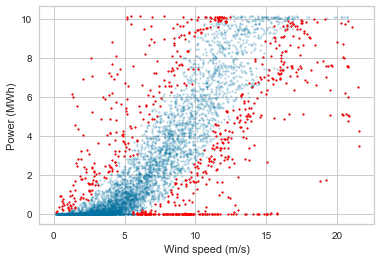

In [97]:
####### Cleaning outliers in the whole data set (train + test) ########
clean_outliers = True

if clean_outliers:
    # Power curve data
    X['Production'] = y.to_list()
    X['vel'] = X.apply(dtr.get_wind_speed, axis=1)
    X_ = X[['vel','Production']]
    
    # top-curve stacked outliers
    top_stacked = filters.window_range_flag(
        X_.Production, 0.97*X_.Production.max(), X_.Production.max(), X_.vel, 12.5, 2000.)

    # sparse outliers
    max_bin = 0.99*X_.Production.max()
    sparse_outliers = filters.bin_filter(
        X_.Production, X_.vel, 0.1, 0.9*X_.Production.std(), 'median', 0.25, max_bin, 'scalar', 'all')

    # bottom-curve stacked outliers
    bottom_stacked = filters.window_range_flag(X_.vel, 5.75, 40, X_.Production, 0.03, 2000.)
    
    plot_flagged_pc(X_.vel, X_.Production,(top_stacked) | (sparse_outliers) | (bottom_stacked), 0.3)

    # deleting outliers
    #X_.vel = X_.vel[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
    #X_.Production = X_.Production[(~top_stacked) & (~sparse_outliers) & (~bottom_stacked)]
    
    # Transform features
    # pt = PowerTransformer(method="yeo-johnson", standardize=True)
    # X['Production'] = pt.fit_transform(X['Production'].to_numpy().reshape(-1,1))
    # X['vel'] = pt.fit_transform(X['vel'].to_numpy().reshape(-1,1))
    # X_ = X[['vel','Production']]
    
    # select no-outliers observations 
    #X = X.loc[X['vel'].isin(X_.vel)]
    #del X['vel']
    
    # Fix abnormal values in CLCT
    #X.loc[X['CLCT'] < 0, 'CLCT'] = 0.0
     

In [44]:
bottom_stacked[bottom_stacked]

632     True
4013    True
4014    True
4015    True
4017    True
        ... 
5575    True
5576    True
5577    True
5578    True
5579    True
Length: 125, dtype: bool

In [36]:
## Split X in train and test sets

def split_data_by_date(date, X, y):
    """
    It splits X and y sets by a 'Time' value 
    into sets for training and testing. 
        - Return: a dictionary with the four sets
                  (X_train, y_train, X_test, y_test)
    """
    sets = {}
    date_cut = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    
    X_test = X[X['Time'] > date_cut]
    X_train = X[X['Time'] <= date_cut]
    y_train = y[X_train.index]
    y_test = y[X_test.index]
    
    sets['X_train'] = X_train
    sets['X_test'] = X_test
    sets['y_train'] = y_train
    sets['y_test'] = y_test
    
    return sets

train_test_dfs = split_data_by_date('2018-11-13 23:00:00', X, X['Production'])
X_train = train_test_dfs.get('X_train')
X_test = train_test_dfs.get('X_test')
y_train = train_test_dfs.get('y_train')
y_test = train_test_dfs.get('y_test')

In [37]:
del X_train['Production']
del X_test['Production']

In [38]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    cape = metric.get_cape(actual, pred)
    return rmse, mae, r2, cape

In [41]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [42]:
X_train_2.shape

(4209, 6)

### Multiple Adaptative Regression Splines (MARS)
<a id="mars"></a>

In [158]:
# for k_best in range(1,4):
    # print('------- k_best_features = {} ----------'.format(k_best))
    
## Feature engineering pipeline #####
feat_adder = dtr.NewFeaturesAdder(add_time_feat=False, add_cycl_feat=False, add_inv_T=False, add_interactions=False)

drop_lst = []
if feat_adder.get_params().get('add_cycl_feat'):
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month"]
else:
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V"]

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [(
                                    'drop_columns', 'drop', drop_lst)
                                ])

# transforming target because of its skweed distribution.
tt = Pipeline(steps=[
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)), 
])

feat_eng_pipeline = Pipeline(steps=[
    ('attr_adder', feat_adder), 
    ('pre_processing', pre_process),
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),   
])


X_train_pped = feat_eng_pipeline.fit_transform(X_train_2)
X_test_pped = feat_eng_pipeline.transform(X_test_2)

#### 
# Feature selection
feature_names = X_train_2.drop(drop_lst, axis=1).columns
selec_k_best = SelectKBest(mutual_info_regression, k=1)        

# make scorers
cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

## Modeling: MARS using py-earth ######
# mars = TransformedTargetRegressor(
#     Earth(feature_importance_type='gcv'),
#     transformer=PowerTransformer(method="yeo-johnson"),
#     check_inverse=True
# )
mars = Earth(feature_importance_type='gcv')

pipeline = Pipeline([("univariate_sel", selec_k_best), ("mars", mars)])


#param_grid = {'mars__regressor__max_degree': [3,4,5], 
#              'mars__regressor__allow_linear': [False, True], 
#              'mars__regressor__penalty': [0.,1.,2.,3.,4.,5.,6.],
#              'univariate_sel__k': list(range(1,3)),
#              }

param_grid = {'mars__max_degree': [3,4,5], 
              'mars__allow_linear': [False, True], 
              'mars__penalty': [0.,1.,2.,3.,4.,5.,6.],# 
              'univariate_sel__k': list(range(1,3)),
              }

# Cross validation and hyper-parameter tunning with grid seach
scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE': 'neg_mean_absolute_error', 'R2':'r2' , 'CAPE': cape_scorer}
n_splits = 7
tscv = TimeSeriesSplit(n_splits)
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=tscv,
    scoring=scoring, 
    refit='CAPE',
    n_jobs=-1
)

grid_search.fit(X_train_pped, y_train_2)

best_mars = grid_search.best_estimator_

experiment_name = 'WF1: MARS'
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    
    # Feature selection with the best k value obtanined in Grid Search
    selec_k_best = SelectKBest(mutual_info_regression, k=grid_search.best_params_['univariate_sel__k'])
    selec_k_best.fit(X_train_pped, y_train_2)
    #X_train_pped = selec_k_best.transform(X_train_pped)
    #X_test_pped = selec_k_best.transform(X_test_pped)
    
    mask =selec_k_best.get_support() #list of booleans
    selected_feat = [] 

    for bool, feature in zip(mask, feature_names):
        if bool:
            selected_feat.append(feature)  


    # predicting on test data
    predictions = best_mars.predict(X_test_pped)

    # build prediction matrix (ID,Production)
    pred_matrix = np.stack((np.array(y_test_2.index.to_series()).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])
    
    # fix negative values in target predictions
    df_pred.loc[df_pred['Production'] < 0, 'Production'] = 0.0

    # print score
    results = grid_search.cv_results_
    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_CV = results['mean_test_%s' % scorer][best_index]
        best_CV_std = results['std_test_%s' % scorer][best_index]
        
        if (scorer=='RMSE') or (scorer=='MAE') or (scorer=='CAPE'):
            print('Best CV {0}:{1:.2f}, std:{2:.2f}'.format(scorer,-best_CV,best_CV_std))
        else:
            print('Best CV {0}:{1:.2f}, std:{2:.2f}'.format(scorer,best_CV,best_CV_std))           
     
    print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
    print('Test R2: ', r2_score(y_test_2, predictions))
    print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))

    ### MLFlow logging ####
    (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)
    mlflow.set_tag("grid_searh_best_params", grid_search.best_params_)

    # pre-processing
    mlflow.log_param("clean_outliers", clean_outliers)
    mlflow.log_param("selected_features", selected_feat)
    mlflow.log_param("k_best_features", best_mars.get_params().get("univariate_sel__k"))

    # grid search parameters
    mlflow.log_param("max_degree", best_mars.get_params().get("mars__max_degree"))
    mlflow.log_param("penalty", best_mars.get_params().get("mars__penalty"))
    mlflow.log_param("allow_linear", best_mars.get_params().get("mars__allow_linear"))
    mlflow.log_param("CV_splits", n_splits)

    # metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("cape", cape)

    # artifacts
    mlflow.sklearn.log_model(mars, "mars")
    # mlflow.log_artifact()

Best CV CAPE:30.94, std:3.86
Best CV MAE:0.52, std:0.19
Best CV R2:0.88, std:0.02
Best CV RMSE:0.81, std:0.23
Test CAPE:  18.78801649653578
Test R2:  0.9373479703580943
Test rmse:  0.8586008822177581


In [190]:
mars.named_steps.mars

Earth(allow_linear=True, feature_importance_type='gcv', max_degree=4,
      penalty=4.0)

In [ ]:
real_pred = np.concatenate((np.array(y_test), predictions)).reshape(len(y_test),2)

df_real_pred =  pd.DataFrame(data=real_pred,
                             index=X_test.Time,
                             columns=['real-production','pred-production'])

df_real_pred.iplot(kind='scatter', filename='cufflinks/cf-simple-line')

In [188]:
context.params.get('folder').get('mdl')

'./data/06_models/'

In [ ]:
alg = "MARS"
viz = ValidationCurve(
            mars.get_params().get("mars"),
            param_name="max_degree",
            param_range=np.arange(1, 11),
            cv=tscv,
            scoring=cape_scorer, title="Curva de aprendizaje para {}".format(alg))

viz.fit(X_train_pped, y_train_2)
viz.show("./validation_curves.png")
viz.show(clear_figure=True)

In [44]:
X_train_pped.shape[1]

1

In [29]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

### K - Nearest Neighbohrs (KNN)
<a id="knn"></a>

In [ ]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

## Feature engineering pipeline #####
feat_adder = dtr.NewFeaturesAdder(add_time_feat=False, add_cycl_feat=False, add_inv_T=False, add_interactions=True)

drop_lst = []
if feat_adder.get_params().get('add_cycl_feat'):
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month"]
else:
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V"]

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [(
                                    'drop_columns', 'drop', drop_lst)
                                ])

# transforming target because of its skweed distribution.
tt = Pipeline(steps=[
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)), 
])

feat_eng_pipeline = Pipeline(steps=[
    ('attr_adder', feat_adder), 
    ('pre_processing', pre_process),
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),   
])


X_train_pped = feat_eng_pipeline.fit_transform(X_train_2)
X_test_pped = feat_eng_pipeline.transform(X_test_2)

#### 
# Feature selection
feature_names = X_train_2.drop(drop_lst, axis=1).columns
selec_k_best = SelectKBest(mutual_info_regression, k=1)        

# make scorers
cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

knn_reg = TransformedTargetRegressor(
    KNeighborsRegressor(), 
    transformer=PowerTransformer(method="yeo-johnson", standardize=True),
    check_inverse=False)


#knn_reg = KNeighborsRegressor()
pipeline = Pipeline([("univariate_sel", selec_k_best), ("knn", knn_reg)])

# KNN model
param_grid = {
    'knn__regressor__n_neighbors': list(range(1,50,2)),
    'knn__regressor__algorithm':['auto', 'kd_tree'],
    'knn__regressor__weights': ['uniform','distance'],
    'knn__regressor__metric': ['cityblock','mahalanobis','euclidean'],
    'knn__regressor__p': [1,2],
    'univariate_sel__k': list(range(1,4))
}

#param_grid = {
#    'knn__n_neighbors': list(range(1,50,2)),
#    'knn__algorithm':['auto', 'kd_tree'],
#    'knn__weights': ['uniform','distance'],
#    'knn__metric': ['cityblock','mahalanobis','euclidean'],
#    'knn__p': [1,2],
#    'univariate_sel__k': list(range(1,4))
#}

n_splits=6
tscv = TimeSeriesSplit(n_splits)
scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE': 'neg_mean_absolute_error', 'R2':'r2' , 'CAPE': cape_scorer}
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv= tscv,
    n_jobs=-1,
    scoring=scoring,
    refit='CAPE'
)

grid_search.fit(X_train_pped, y_train_2)

experiment_name = 'WF1: KNN'
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    # Feature selection with the best k value obtanined in Grid Search
    selec_k_best = SelectKBest(mutual_info_regression, k=grid_search.best_params_['univariate_sel__k'])
    selec_k_best.fit(X_train_pped, y_train_2)
    X_train_pped = selec_k_best.transform(X_train_pped)
    X_test_pped = selec_k_best.transform(X_test_pped)
    
    mask =selec_k_best.get_support() #list of booleans
    selected_feat = [] 

    for bool, feature in zip(mask, feature_names):
        if bool:
            selected_feat.append(feature)  
    # Re-train the model with the best parameters found in CV 
    knn_reg2 = TransformedTargetRegressor(
        KNeighborsRegressor(algorithm=grid_search_knn.best_params_['knn__regressor__algorithm'],
                             n_neighbors=grid_search_knn.best_params_['knn__regressor__n_neighbors'],
                             p=grid_search_knn.best_params_['knn__regressor__p'], 
                             weights=grid_search_knn.best_params_['knn__regressor__weights'],
                             metric=grid_search_knn.best_params_['knn__regressor__metric']),
         transformer=PowerTransformer(method="yeo-johnson", standardize=True), check_inverse=False) 
        

    # knn_reg.fit(X_train_pped, y_train_2)
    knn_reg2.fit(X_train_pped, y_train)

    # Testing
    predictions = knn_reg2.predict(X_test_pped)

    # Building prediction matrix (ID,Production)
    pred_matrix = np.stack((np.array(y_test.index.to_series()).astype(int), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

    # print score
    results = grid_search.cv_results_
    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_CV = results['mean_test_%s' % scorer][best_index]
        best_CV_std = results['std_test_%s' % scorer][best_index]
        
        if (scorer=='RMSE') or (scorer=='MAE') or (scorer=='CAPE'):
            print('Best CV {0}:{1:.2f}, std:{2:.2f}'.format(scorer,-best_CV,best_CV_std))
        else:
            print('Best CV {0}:{1:.2f}, std:{2:.2f}'.format(scorer,best_CV,best_CV_std))           
     
    print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
    print('Test R2: ', r2_score(y_test_2, predictions))
    print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))

    ### MLFlow logging ####
    (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)

    mlflow.set_tag("grid_searh_best_params", grid_search_knn.best_params_)

    # pre-processing
    mlflow.log_param("clean_outliers", clean_outliers)
    mlflow.log_param("selected_features", selected_feat)
    mlflow.log_param("k_best_features", param_grid.get("knn__univariate_sel__k"))

    # grid search parameters
    mlflow.log_param("n_neighbors", param_grid.get("knn__regressor__n_neighbors"))
    mlflow.log_param("algorithm", param_grid.get("knn__regressor__algorithm"))
    mlflow.log_param("weights", param_grid.get("knn__regressor__weights"))
    mlflow.log_param("metric", param_grid.get("knn__regressor__metric"))
    mlflow.log_param("CV_splits", n_splits)

    # metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("cape", cape)

    # artifacts
    mlflow.sklearn.log_model(knn_reg2, "knn")
    # mlflow.log_artifact()

In [ ]:
real_pred = np.concatenate((predictions, np.array(y_test))).reshape(len(y_test),2)
df_real_pred =  pd.DataFrame(data=real_pred,
                             index=X_test.Time,
                             columns=['pred-production','real-production'])
df_real_pred.iplot(kind='scatter', filename='cufflinks/cf-simple-line')

In [ ]:
max_n_neighbors = 50
list(range(1, max_n_neighbors, 2))

### Support Vector Machine (SVM)
<a id="svm"></a>

In [ ]:
from sklearn.svm import SVR

In [ ]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [ ]:
## Pre-process pipeline #####
for k_best_features in range(1,10):
    print('------- k_best_features = {} ------'.format(k_best_features))
    drop_lst = ['ID','Time','U','V']
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [(
                                        'drop_columns', 'drop', drop_lst)
                                    ])

    tt = Pipeline(steps=[
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1))) 
        # ('standard_scaler', StandardScaler())
    ])

    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=False, add_inv_T=False)), 
        ('pre_processing', pre_process),
        ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1)),
        # ('standard_scaler', StandardScaler())    
    ])

    X_train_pped = prepare_data_pipeline.fit_transform(X_train_2)
    X_test_pped = prepare_data_pipeline.transform(X_test_2)

    feature_sel = True
    feature_names = X_train_2.drop(drop_lst, axis=1).columns

    # Feature selection 
    if feature_sel: 
        ## using Mutual Information
        selec_k_best = SelectKBest(mutual_info_regression, k=k_best_features)
        selec_k_best.fit(X_train_pped, y_train_2)
        X_train_pped = selec_k_best.transform(X_train_pped)
        X_test_pped = selec_k_best.transform(X_test_pped)

        mask =selec_k_best.get_support() #list of booleans
        selected_feat = [] 

        for bool, feature in zip(mask, feature_names):
            if bool:
                selected_feat.append(feature)  

    # make scorers
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

    param_grid = {
        'kernel': ('linear', 'rbf','poly'), 
        'C':[0.01, 1, 0.1, 10, 100],
        'gamma': [0.00001, 0.001, 1],
        'epsilon':[0.1,0.3,0.5]
    }

    svm_reg = SVR()
    n_splits=9
    grid_search_svm = GridSearchCV(
        svm_reg, 
        param_grid, 
        cv= TimeSeriesSplit(n_splits),
        scoring=cape_scorer,
        n_jobs=-1
    )

    grid_search_svm.fit(X_train_pped, y_train_2)

    experiment_name = 'WF1: SVM'
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        svm_reg2 = SVR(kernel = grid_search_svm.best_params_['kernel'],
                       C = grid_search_svm.best_params_['C'],
                       gamma = grid_search_svm.best_params_['gamma'],
                       epsilon = 0.1)

        ttreg = TransformedTargetRegressor(regressor=svm_reg2, transformer=tt, check_inverse=False)

        ttreg.fit(X_train_pped, y_train_2)
        # svm_reg2.fit(X_train_pped, y_train_2)

        # learning curves
        train_size = np.linspace(0.1, 1.0, 7)
        train_sizes, train_scores, validation_scores = learning_curve(estimator = ttreg,
                                                                      X = X_train_pped,
                                                                      y = y_train_2, 
                                                                      train_sizes = train_size,
                                                                      scoring = cape_scorer)

        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)

        plt.style.use('seaborn')
        plt.plot(train_sizes, train_scores_mean, label = 'Training error')
        plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
        plt.ylabel('CAPE', fontsize = 14)
        plt.xlabel('Training set size', fontsize = 14)
        plt.title('Learning curves for SVM', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()

        # Validation curves
        param_range = list(range(0,30,2))
        train_scores, test_scores = validation_curve(SVR(kernel = grid_search_svm.best_params_['kernel'],
                                                         gamma = grid_search_svm.best_params_['gamma'],
                                                         epsilon = grid_search_svm.best_params_['epsilon']),
                                                     X_train_pped, y_train_2, "C",param_range, cv=5)

        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)

        plt.style.use('seaborn')
        plt.plot(param_range, train_mean, label="training accuracy")
        plt.plot(param_range, test_mean, linestyle="--", label="validation accuracy")
        plt.ylabel('Accuracy', fontsize = 14)
        plt.xlabel('C', fontsize = 14)
        plt.title('Validation curve for SVM', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()

        # Testing
        predictions = ttreg.predict(X_test_pped)
        #predictions = svm_reg2.predict(X_test_pped)

        # Building prediction matrix (ID,Production)
        pred_matrix = np.stack((np.array(y_test_2.index.to_series()).astype(int), predictions), axis=-1)
        df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

        print('Best CV score:', -grid_search_svm.best_score_)
        print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
        print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))
        print('Test R2: ', r2_score(y_test_2, predictions))

        ### MLFlow logging ####
        (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)

        mlflow.set_tag("grid_searh_best_params", grid_search_svm.best_params_)

        # pre-processing
        mlflow.log_param("clean_outliers", clean_outliers)
        mlflow.log_param("feature_selection", feature_sel)
        mlflow.log_param("selected_features", selected_feat)
        mlflow.log_param("k_best_features", k_best_features)

        # grid search parameters
        mlflow.log_param("kernel", param_grid.get("kernel"))
        mlflow.log_param("C", param_grid.get("C"))
        mlflow.log_param("gamma", param_grid.get("gamma"))
        mlflow.log_param("epsilon", param_grid.get("epsilon"))
        mlflow.log_param("CV_splits", n_splits)

        # metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("cape", cape)

        # artifacts
        mlflow.sklearn.log_model(ttreg, "svm")
        # mlflow.log_artifact()

### Random Forests
<a id="RF"></a>

In [ ]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

for k_best_features in range(1,10):
    print('------- k_best_features = {} ------'.format(k_best_features))
    
    drop_lst = ['ID','Time','U','V','month','hour','w_dir']
    pre_process = ColumnTransformer(remainder = 'passthrough',
                                    transformers = [(
                                        'drop_columns', 'drop', drop_lst)
                                    ])
    
    # tt = Pipeline(steps=[
    #     ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
    #     ('normalization', MinMaxScaler(feature_range=(0, 1))),
    #     ('standard_scaler', StandardScaler())
    # ])
    
    prepare_data_pipeline = Pipeline(steps=[
        ('attr_adder', dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=False)), 
        ('pre_processing', pre_process)
        # ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),
        # ('normalization', MinMaxScaler(feature_range=(0, 1)),
        # ('standard_scaler', StandardScaler())    
    ])
    
    X_train_pped = prepare_data_pipeline.fit_transform(X_train_2)
    X_test_pped = prepare_data_pipeline.transform(X_test_2)
    
    feature_sel = True
    feature_names = X_train_2.drop(drop_lst, axis=1).columns
    
    # Feature selection 
    if feature_sel: 
        ## using Mutual Information
        selec_k_best = SelectKBest(mutual_info_regression, k=k_best_features)
        selec_k_best.fit(X_train_pped, y_train_2)
        X_train_pped = selec_k_best.transform(X_train_pped)
        X_test_pped = selec_k_best.transform(X_test_pped)
    
        mask =selec_k_best.get_support() #list of booleans
        selected_feat = [] 
    
        for bool, feature in zip(mask, feature_names):
            if bool:
                selected_feat.append(feature)  
    
    # make scorers
    cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)
    
    # hyperparameters
    # n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
    # max_features = ['auto', 'sqrt']
    # m# ax_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
    # max_depth.append(None)
    # min_samples_split = [5, 10, 15, 20]
    # min_samples_leaf = [1, 2, 4]
    # bootstrap = [True, False]
    
    # Create the random grid
    # random_grid = {'n_estimators': n_estimators,
    #                'max_features': max_features,
    #                'max_depth': max_depth,
    #                'min_samples_split': min_samples_split,
    #                'min_samples_leaf': min_samples_leaf,
    #                'bootstrap': bootstrap}
    # 
    # Use the random grid to search for best hyperparameters ranges
    # rf = RandomForestRegressor()
    # rf_random = RandomizedSearchCV(estimator = rf, 
    #                                param_distributions = random_grid, 
    #                                n_iter = 100, cv = 3,
    #                                random_state=42, 
    #                                n_jobs = -1)
    # 
    # rf_random.fit(X_train_pped, y_train_2)
    # print(rf_random.best_params_)
    
    param_grid = {
        'n_estimators': [75, 150, 225],
        'max_features': ['sqrt', 'log2', 'auto'],
        'max_depth': [10, 50, 100],
        'min_samples_split': [15, 30, 45],
        'min_samples_leaf': [4, 6, 8],
    }
    
    n_splits = 7 
    forest_reg = RandomForestRegressor(bootstrap=True, random_state=42)
    grid_search = GridSearchCV(
        forest_reg, 
        param_grid, 
        cv=TimeSeriesSplit(n_splits),
        scoring=cape_scorer,
        n_jobs=-1
    )
    
    grid_search.fit(X_train_pped, y_train_2)
    
    experiment_name = 'WF1: Ranfom Forest'
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        forest_reg2 = RandomForestRegressor(
            n_estimators=grid_search.best_params_['n_estimators'],
            max_features=grid_search.best_params_['max_features'],
            max_depth=grid_search.best_params_['max_depth'],
            min_samples_split=grid_search.best_params_['min_samples_split'],
            min_samples_leaf=grid_search.best_params_['min_samples_leaf']
            
        )
    
        # ttreg = TransformedTargetRegressor(regressor=forest_reg2, transformer=tt, check_inverse=False)
    
        # ttreg.fit(X_train_pped, y_train_2)
        forest_reg2.fit(X_train_pped, y_train_2)
    
        # learning curves
        train_size = np.linspace(0.1, 1.0, 7)
        train_sizes, train_scores, validation_scores = learning_curve(estimator = forest_reg2,
                                                                      X = X_train_pped,
                                                                      y = y_train_2, 
                                                                      train_sizes = train_size,
                                                                      scoring = cape_scorer)
    
        train_scores_mean = -train_scores.mean(axis = 1)
        validation_scores_mean = -validation_scores.mean(axis = 1)
    
        plt.style.use('seaborn')
        plt.plot(train_sizes, train_scores_mean, label = 'Training error')
        plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
        plt.ylabel('CAPE', fontsize = 14)
        plt.xlabel('Training set size', fontsize = 14)
        plt.title('Learning curves for RF', fontsize = 18, y = 1.03)
        plt.legend()
        plt.show()
        plt.close()
    
        # Validation curves
        #param_range = list(range(1,400,10))
        #train_scores, test_scores = validation_curve(RandomForestRegressor(
        #    max_features=grid_search.best_params_['max_features'],
        #    max_depth=grid_search.best_params_['max_depth'],
        #    min_samples_split=grid_search.best_params_['min_samples_split'],
        #    min_samples_leaf=grid_search.best_params_['min_samples_leaf']
        #), X_train_pped, y_train, "n_estimators",param_range, cv=TimeSeriesSplit(n_splits))
    #
        #train_mean = np.mean(train_scores, axis=1)
        #train_std = np.std(train_scores, axis=1)
        #test_mean = np.mean(test_scores, axis=1)
        #test_std = np.std(test_scores, axis=1)
    #
        #plt.style.use('seaborn')
        #plt.plot(param_range, train_mean, label="training accuracy")
        #plt.plot(param_range, test_mean, linestyle="--", label="validation accuracy")
        #plt.ylabel('Accuracy', fontsize = 14)
        #plt.xlabel('# estimators', fontsize = 14)
        #plt.title('Validation curve for RF', fontsize = 18, y = 1.03)
        #plt.legend()
        #plt.show()
        #plt.close()
    
        # Testing
        # predictions = ttreg.predict(X_test_pped)
        predictions = forest_reg2.predict(X_test_pped)
    
        # Building prediction matrix (ID,Production)
        pred_matrix = np.stack((np.array(y_test_2.index.to_series()).astype(int), predictions), axis=-1)
        df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])
    
        print('Best CV score:', -grid_search.best_score_)
        print('Test CAPE: ', metric.get_cape(y_test_2, predictions))
        print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))
        print('Test R2: ', r2_score(y_test_2, predictions))
    
        ### MLFlow logging ####
        (rmse, mae, r2, cape) = eval_metrics(y_test_2, predictions)
    
        mlflow.set_tag("grid_searh_best_params", grid_search.best_params_)
    
        # pre-processing
        mlflow.log_param("clean_outliers", clean_outliers)
        mlflow.log_param("feature_selection", feature_sel)
    
        if feature_sel:
            mlflow.log_param("k_best_features", k_best_features)
            mlflow.log_param("selected_features", selected_feat)
    
        # grid search parameters
        mlflow.log_param("n_estimators", param_grid.get("n_estimators"))
        mlflow.log_param("max_features", param_grid.get("max_features"))
        mlflow.log_param("max_depth", param_grid.get("max_depth"))
        mlflow.log_param("min_samples_leaf", param_grid.get("min_samples_leaf"))
        mlflow.log_param("min_samples_split", param_grid.get("min_samples_split"))
    
    
        # metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("cape", cape)
    
        # artifacts
        mlflow.sklearn.log_model(forest_reg2, "RF")
        # mlflow.log_artifact()
    

In [118]:
np.logspace(-6, 6, 20)

array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06])

### Artificial Neural Network (ANN)
<a id="ann"></a>

In [124]:
X_train_2 = X_train.copy()
X_test_2 = X_test.copy()
y_train_2 = y_train.copy()
y_test_2 = y_test.copy()

In [71]:
def build_model(n_hidden=1, n_neurons = 10, learning_rate = 3e-3, input_shape=[5]):
    import tensorflow as tf 
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(tf.keras.layers.Dense(1))
    optimizer = tf.keras.optimizers.SGD(lr = learning_rate)
    model.compile(loss = "mse", optimizer = optimizer)
    
    return model
        

In [ ]:


## Feature engineering pipeline #####
feat_adder = dtr.NewFeaturesAdder(add_time_feat=True, add_cycl_feat=True, add_inv_T=True, add_interactions=True)

drop_lst = []
if feat_adder.get_params().get('add_cycl_feat'):
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V", "wdir", "hour", "month"]
else:
    if feat_adder.get_params().get('add_inv_T'):
        drop_lst = ["ID", "Time", "U", "V", "T"]
    else:
        drop_lst = ["ID", "Time", "U", "V"]

pre_process = ColumnTransformer(remainder = 'passthrough',
                                transformers = [(
                                    'drop_columns', 'drop', drop_lst)
                                ])


feat_eng_pipeline = Pipeline(steps=[
    ('attr_adder', feat_adder), 
    ('pre_processing', pre_process),
    ('powertransformer', PowerTransformer(method='yeo-johnson', standardize=True)),   
])


X_train_pped = feat_eng_pipeline.fit_transform(X_train_2)
X_test_pped = feat_eng_pipeline.transform(X_test_2)

#### 
# Feature selection
feature_names = X_train_2.drop(drop_lst, axis=1).columns
selec_k_best = SelectKBest(mutual_info_regression, k=1)        

# make scorers
cape_scorer = make_scorer(metric.get_cape, greater_is_better=False)

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=build_model, epochs=10, batch_size=3)


#knn_reg = KNeighborsRegressor()
pipeline = Pipeline([("univariate_sel", selec_k_best), ("ann", keras_reg)])

# KNN model
param_grid = {
    'ann__n_hidden': [1],
    'ann__n_neurons':[20, 30],
    'ann__learning_rate':[3e-3],
    'ann__input_shape':[8],
    'univariate_sel__k': [8] }

n_splits=7
tscv = TimeSeriesSplit(n_splits)
scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE': 'neg_mean_absolute_error', 'R2':'r2' , 'CAPE': cape_scorer}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring = scoring,
    refit='CAPE',
    cv=tscv,
    n_jobs=-1,
)

gcv = grid_search.fit(X_train_pped, y_train_2.to_numpy())

experiment_name = 'WF1: ANN'
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    # Feature selection with the best k value obtanined in Grid Search
    selec_k_best = SelectKBest(mutual_info_regression, k=grid_search.best_params_['univariate_sel__k'])
    selec_k_best.fit(X_train_pped, y_train_2)
    X_train_pped = selec_k_best.transform(X_train_pped)
    X_test_pped = selec_k_best.transform(X_test_pped)
    
    mask =selec_k_best.get_support() #list of booleans
    selected_feat = [] 

    for bool, feature in zip(mask, feature_names):
        if bool:
            selected_feat.append(feature)                                                             

    # re-training with the best model parameters
    best_model = gcv.best_estimator_.named_steps.get('ann').model
    history = best_model.fit(X_train_pped, y_train_2.to_numpy(), epochs=100)
    
    # plotting learning curves
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0.4, 0.6)
    plt.show

    # evaluate on test set
    # mse_test = best_model.evaluate(X_test_pped, y_test_2.to_numpy().reshape(-1,1))

    # predict
    predictions = best_model.predict(X_test_pped)

    # Building prediction matrix (ID,Production)
    pred_matrix = np.stack((np.array(y_test_2.index.to_series()).reshape(-1,1), predictions), axis=-1)
    df_pred = pd.DataFrame(data=pred_matrix.reshape(-1,2), columns=['ID','Production'])

    print('Test CAPE: ', metric.get_cape(y_test_2.to_numpy().reshape(-1), predictions.reshape(-1)))
    print('Test rmse: ', np.sqrt(mean_squared_error(y_test_2, predictions)))
    print('Test R2: ', r2_score(y_test_2, predictions))

    ### MLFlow logging ####
    (rmse, mae, r2, cape) = eval_metrics(y_test_2.to_numpy().reshape(-1), predictions.reshape(-1))

    mlflow.set_tag("grid_searh_best_params", grid_search.best_params_)

    # pre-processing
    mlflow.log_param("clean_outliers", clean_outliers)
    mlflow.log_param("selected_features", selected_feat)
    # mlflow.log_param("k_best_features", k_bests)

    # grid search parameters
    mlflow.log_param("n_hidden", param_grid.get("ann_n_hidden"))
    mlflow.log_param("n_neuron", param_grid.get("ann_n_neuron"))
    mlflow.log_param("learning_rate", param_grid.get("ann_learning_rate"))

    # metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("cape", cape)

    # artifacts
    # mlflow.sklearn.log_model(best_model, "ANN")


